# Projekt: Erkennung von Spurmarkierungen
In diesem Projekt sollen Spurmarkierungen in zwei bestehenden Datensätzen erkannt werden: 
1. Udacity Nanodegree "Self-Driving Car Engineer" (https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)
2. KITTI-Datensatz zur Erkennung von Spurmarkierungen (http://www.cvlibs.net/datasets/kitti/eval_road.php)

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os

print('Willkommen beim Projekt "Erkennung von Spurmarkierungen"')

Willkommen beim Projekt "Erkennung von Spurmarkierungen"


# Exkurs 1: Kamerakalibrierung zur Entzerrung der Bilder
Die vorhandenen Bilder sind aufgrund der Linsen- und Kameraeigenschaften verzerrt. Entzerren Sie die Bilder mithilfe der Kamerakalibrierungsroutinen von OpenCV (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) und den aufgezeichneten Bildern.

In [3]:
import numpy as np
import cv2 as cv
import glob

# Code wurde überarbeitet von opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

cols = 9
rows = 6

objp = np.zeros((rows*cols,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob(pathname='img/Udacity/calib/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (rows,cols), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
    else:
        print("could not find corners")

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, (1280,720), None, None)
print(mtx)
print(dist)

could not find corners
could not find corners
could not find corners
[[1.15694047e+03 0.00000000e+00 6.65948821e+02]
 [0.00000000e+00 1.15213880e+03 3.88784788e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-2.37638058e-01 -8.54041696e-02 -7.90999653e-04 -1.15882218e-04
   1.05725981e-01]]


# Exkurs 2: Perspektivtransformation
Durch die Kameraperspektive wird die Krümmung der gefundenen Spurmarkierungen nicht der realen Fahrstreifenkrümmung entsprechen. Transformieren Sie daher die Bilder der Kameraperspektive in eine Vogelperspektive, die der realen Fahrstreifenkrümmung entspricht.

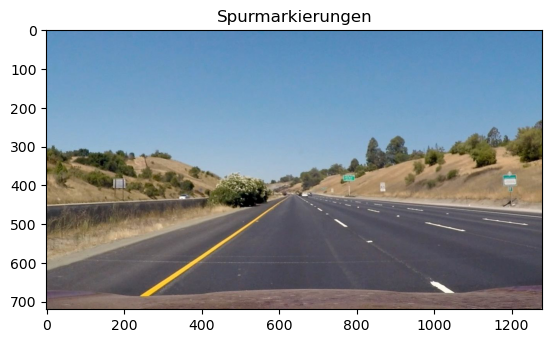

1280 720


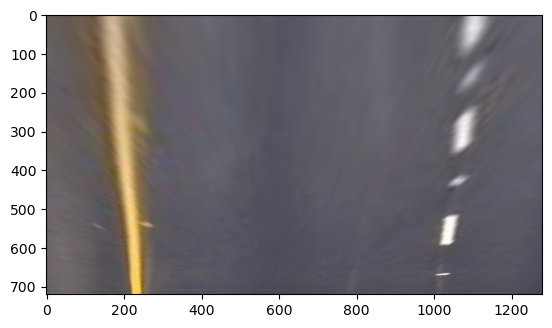

In [4]:
# einlesen eines Beispielbildes
img1 = cv.imread('./img/Udacity/image001.jpg', -1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Spurmarkierungen')
plt.show()

h,  w = img1.shape[:2]
print(w, h)

# definieren Sie die für eine Perspektivtransformation notwendigen Quell- und Zielpunkte
src = np.float32(((580, 450), (700, 450), (220, 600), (1100, 600)))
dst = np.float32(((0, 0), (w, 0), (0, h), (w, h)))



M = cv.getPerspectiveTransform(src,dst)
img1_warp = cv.warpPerspective(img1,M,(img1.shape[1], img1.shape[0]))
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
plt.show()

# Aufgabe 3: Erkennung von Fahrbahnmarkierungen
Erkennen Sie die Fahrbahnmarkierungen bzw. Fahrstreifen auf den Bildquellen von Udacity. Wenden Sie dabei die aus der Vorlesung bekannten Verfahren an. Gerne dürfen Sie auch weitere Verfahren aus anderen Quellen verwenden. Folgende Ziele müssen bei der finalen Abgabe erreicht werden: 
- **Segmentierung**: schränken Sie das Bild auf den Bereich ein, in dem sich die Spurmarkierungen befinden
- **Vorverarbeitung**: führen Sie eine Kamerakalibrierung (für Udacity-Bildquellen) und die Perspektivtransformation durch
- **Farbräume, Histogramme**: erkennen Sie die Spurmarkierungen in den Farben der angegebenen Quellen. Sofern weitere Spurmarkierungen auf dem Bild gefunden werden, müssen diejenigen Spurmarkierungen priorisiert werden, die die eigene Fahrspur begrenzen
- **Allgemeines**: Die Verarbeitung von Bildern muss in Echtzeit stattfinden --> Ziel: > 20 FPS
- **Allgemeines**: Beschleunigen Sie die Verarbeitung durch weitere Maßnahmen weitere Maßnahmen überlegen (bspw. Erkennung der Spurmarkierung in den ersten Frames, Tracking der Spurmarkierung in weiteren Frames solange, bis sich Spurmarkierungspositionen zu stark ändern)
- **Minimal**: relevante Spurmarkierungen werden im Video "project_video" durchgehend erkannt 
- **Zusatz**: relevante Spurmarkierungen werden im Video "challenge_video" und "harder_challenge_video" durchgehend erkannt
- **Zusatz**: relevante Spurmarkierungen werden auf den Datensatz KITTI angewendet. Welche Anpassungen müssen vorgenommen werden, damit Ihr Algorithmus übertragen werden kann?
- **Zusatz**: Erarbeiten Sie weitere Maßnahmen zur Geschwindigkeitsverbesserung Ihres Algorithmus
- **Zusatz**: Erkennen Sie Objekte im Bild und visualisieren Sie diese (z.B. weitere Fahrzeuge, Motorräder, etc.)Die Objekterkennung bitte so implementieren, dass sie deaktivierbar ist und nicht in FPS-Berechnung einzahlt.

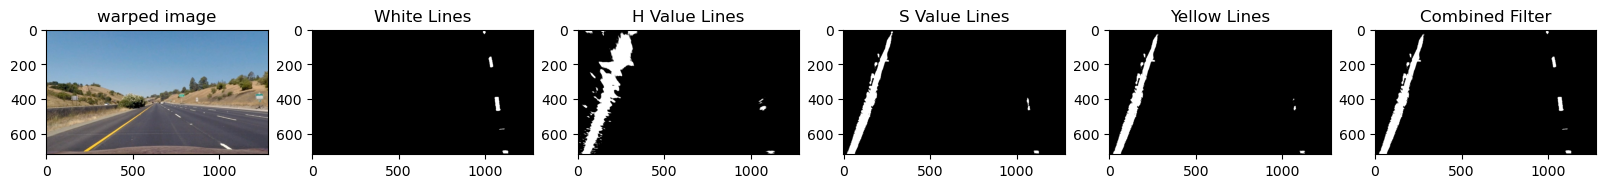

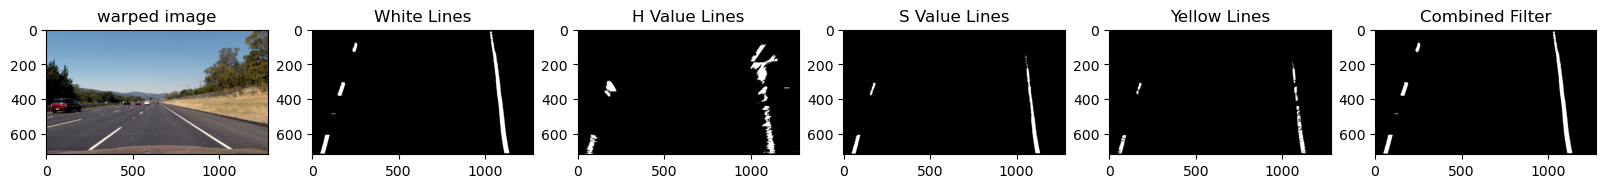

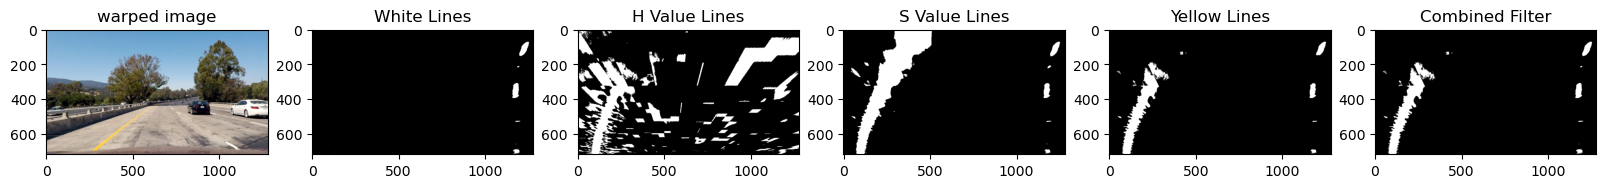

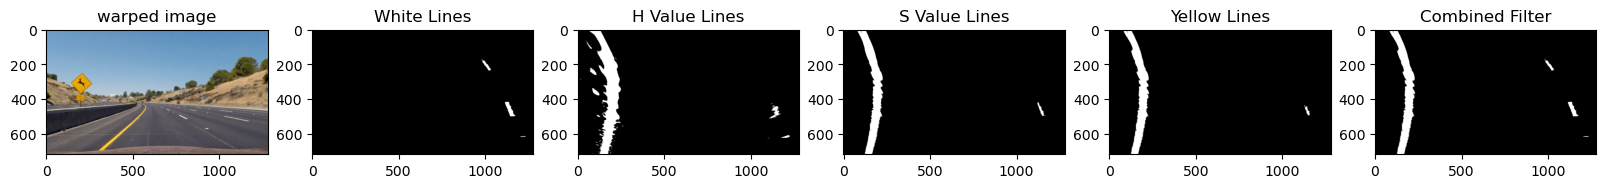

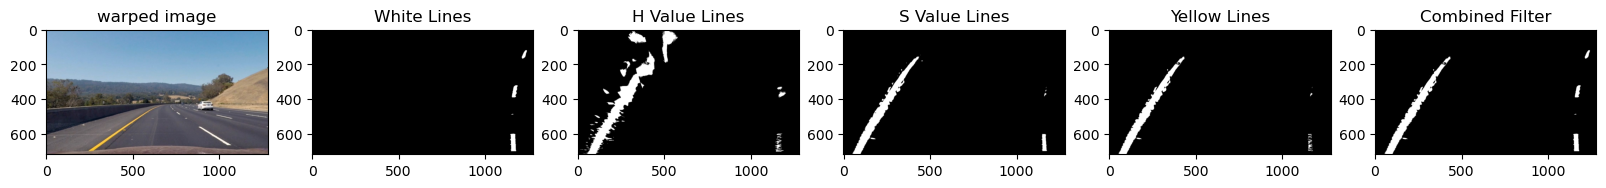

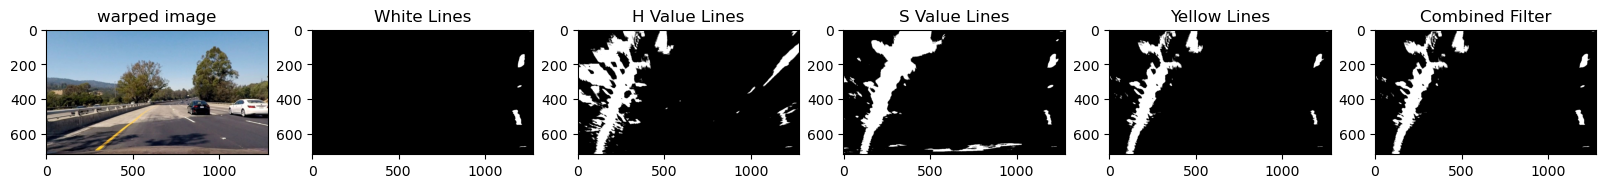

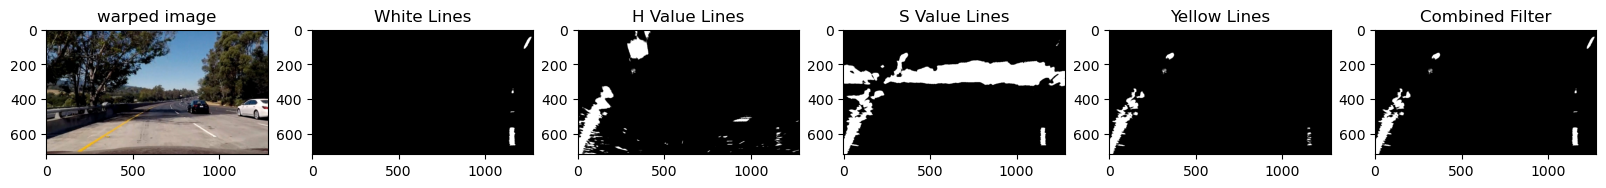

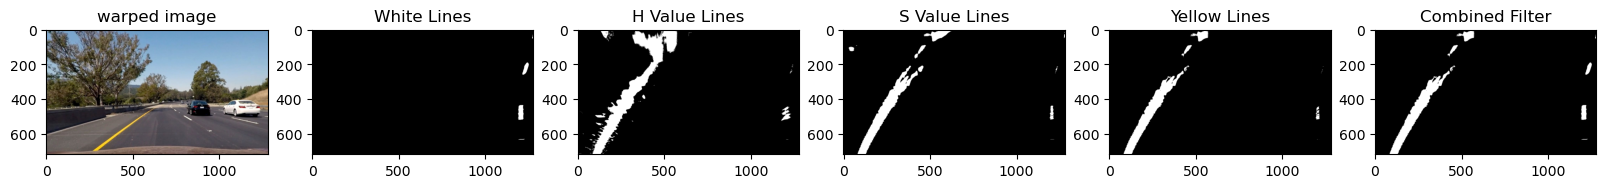

In [5]:
# Camera Calibrierung
images = glob.glob(pathname='img/Udacity/*.jpg')

def filter_yellow_and_white_lines(img):
    hls = cv.cvtColor(img, cv.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    l_thresh = (215, 255)
    white_mask = np.zeros_like(l_channel)
    white_mask[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    h_thresh = (17, 46)
    h_thresh_filtered = np.zeros_like(h_channel)
    h_thresh_filtered[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    s_thresh = (89, 255)
    s_thresh_filtered = np.zeros_like(s_channel)
    s_thresh_filtered[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    final = np.zeros_like(h_channel)
    final[(((s_thresh_filtered == 1) & (h_thresh_filtered == 1))) | white_mask ==1] = 255

    return final

    

def filter_lines(img):
    hls = cv.cvtColor(img, cv.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # filter white lines with lightness
    l_thresh = (215, 255)
    white_mask = np.zeros_like(l_channel)
    white_mask[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    white_filtered = np.zeros_like(h_channel)
    white_filtered[(white_mask == 1)] = 255
    plt.subplot(1,6,2)
    plt.title("White Lines")
    plt.imshow(white_filtered, cmap='gray')

    # filter yellow lines with saturation and hue
    h_thresh = (17, 46)
    h_thresh_filtered = np.zeros_like(h_channel)
    h_thresh_filtered[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    h_filtered = np.zeros_like(h_channel)
    h_filtered[(h_thresh_filtered == 1)] = 255
    plt.subplot(1,6,3)
    plt.title("H Value Lines")
    plt.imshow(h_filtered, cmap='gray')

    s_thresh = (89, 255)
    s_thresh_filtered = np.zeros_like(s_channel)
    s_thresh_filtered[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    s_filtered = np.zeros_like(h_channel)
    s_filtered[(s_thresh_filtered == 1)] = 255
    plt.subplot(1,6,4)
    plt.title("S Value Lines")
    plt.imshow(s_filtered, cmap='gray')

    yellow_mask = cv.bitwise_and(h_thresh_filtered, s_thresh_filtered)

    yellow_filtered = np.zeros_like(h_channel)
    yellow_filtered[(yellow_mask == 1)] = 255
    plt.subplot(1,6,5)
    plt.title("Yellow Lines")
    plt.imshow(yellow_filtered, cmap='gray')

    final = np.zeros_like(h_channel)
    final[(((s_thresh_filtered == 1) & (h_thresh_filtered == 1))) | white_mask ==1] = 255

    return final
# einlesen eines Beispielbildes
#img1 = cv.imread('./img/Udacity/image004.jpg', -1)
for img in images:
    img1 = cv.imread(img, -1)
    plt.figure(figsize=(20,10))
    h,  w = img1.shape[:2]
    # Anwenden Camera Kalibrierung
    img1 = cv.undistort(img1, mtx, dist, None, mtx)
    # definieren Sie die für eine Perspektivtransformation notwendigen Quell- und Zielpunkte
    src = np.float32(((560, 450), (720, 450), (200, 700), (1200, 700)))
    dst = np.float32(((0, 0), (w, 0), (0, h), (w, h)))

    M = cv.getPerspectiveTransform(src,dst)
    img1_warp = cv.warpPerspective(img1,M,(img1.shape[1], img1.shape[0]))

    plt.subplot(1,6,1)
    plt.title("warped image")
    plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))

    filtered_lines = filter_lines(img1_warp)
   
    plt.subplot(1,6,6)
    plt.imshow(filtered_lines, cmap='gray')
    plt.title("Combined Filter")
    

    plt.show()

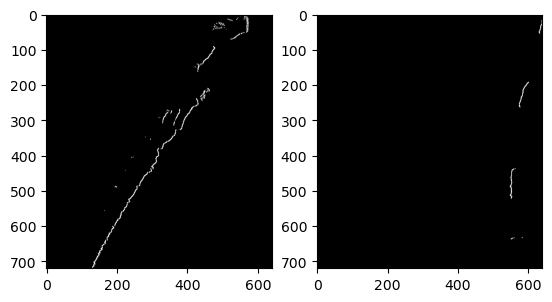

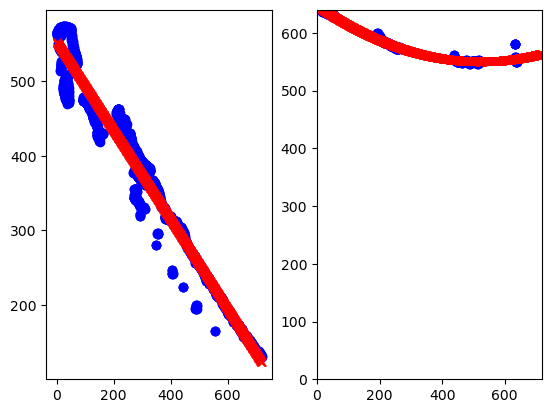

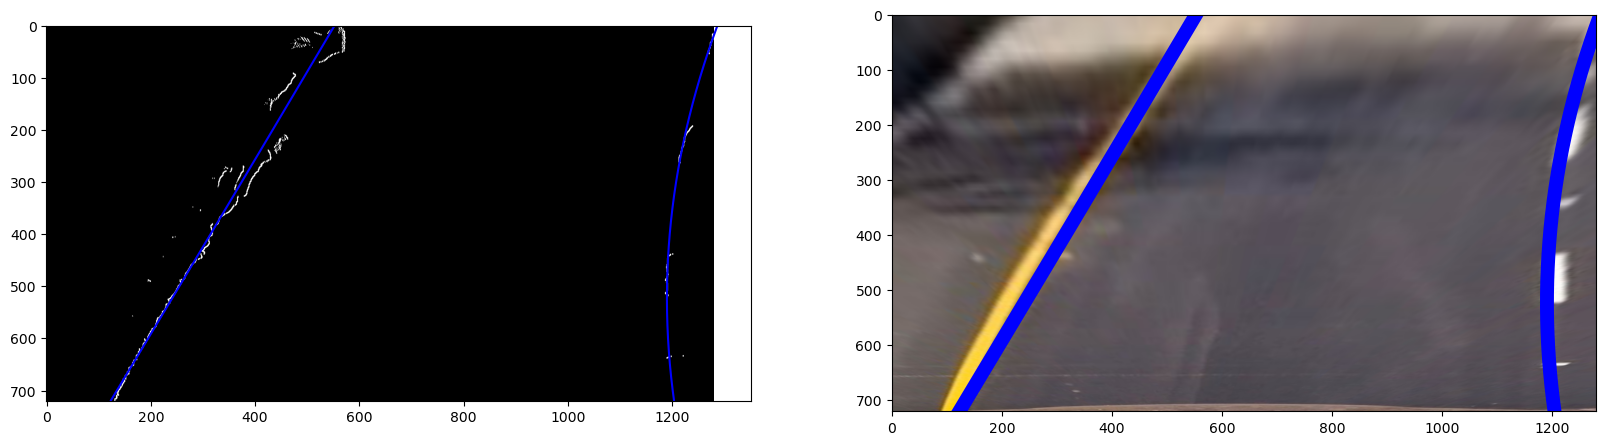

In [6]:
# Anwenden Polyfitting

# define width and height of image
w = len(filtered_lines[1])
h = len(filtered_lines)

# Teile Bild in 2 und wende filterung an
left_half = filtered_lines[:,0:int(w/2)]
right_half = filtered_lines[:,int(w/2):w]

# Wende Prewitt Kantenfilter an um rechte bzw. linke Kante von jeweiliger Bildhälfte zu filtern
kernel = np.array([[1,0,-1],[1,0,-1],[1,0,-1]],np.float32)
left_half = cv.filter2D(left_half,-1,kernel)
kernel = np.array([[-1,0,1],[-1,0,1],[-1,0,1]],np.float32)
right_half = cv.filter2D(right_half,-1,kernel)

plt.subplot(1,2,1)
plt.imshow(left_half, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(right_half, cmap='gray')
plt.show()


# Wandle bild in Menge an Punkten um

left_y, left_x = np.where(left_half == np.uint32(255))
right_y, right_x = np.where(right_half == np.uint32(255))

# Wende Polyfitting an mit Polynom 2. Grades

# polyfit um Kurve zu finden
# Achsen wurden vertauscht, da sonst Kurve nicht richtig erfasst wird!
def get_poly(x_n, y_n):
    w = np.polyfit(y_n, x_n, 2)

    xn = np.arange(0, h, 1)
    yn1 = np.poly1d(w)(xn)

    return (xn, yn1)

left_yn, left_xn = get_poly(left_x, left_y)
right_yn, right_xn = get_poly(right_x, right_y)

# Kurven dargestellt mit vertauschten achsen!
plt.subplot(1,2,1)
plt.plot(left_y, left_x, 'ob', label='Points')
plt.plot(left_yn, left_xn, 'xr', label='Polyn. 2. Grades')

plt.subplot(1,2,2)
plt.plot(right_y, right_x, 'ob', label='Points')
plt.plot(right_yn, right_xn, 'xr', label='Polyn. 2. Grades')

plt.xlim([0, len(left_half)])
plt.ylim([0, len(left_half[0])])
plt.show()


# Kombiniere linke und rechte Hälfte
combined = np.concatenate((left_half, right_half), axis=1)
right_xn += np.uint32(w/2) # addiere die hälfte der Bild breite zu eingezeichneter Linie

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(combined, cmap='gray')

plt.plot(left_xn, left_yn, '-b', label='Polyn. 2. Grades')
plt.plot(right_xn, right_yn, '-b', label='Polyn. 2. Grades')

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
plt.plot(left_xn, left_yn, '-b', linewidth = 10, label='Polyn. 2. Grades')
plt.plot(right_xn, right_yn, '-b',  linewidth = 10, label='Polyn. 2. Grades')

plt.xlim([0, w])
plt.ylim([h, 0])

plt.show()


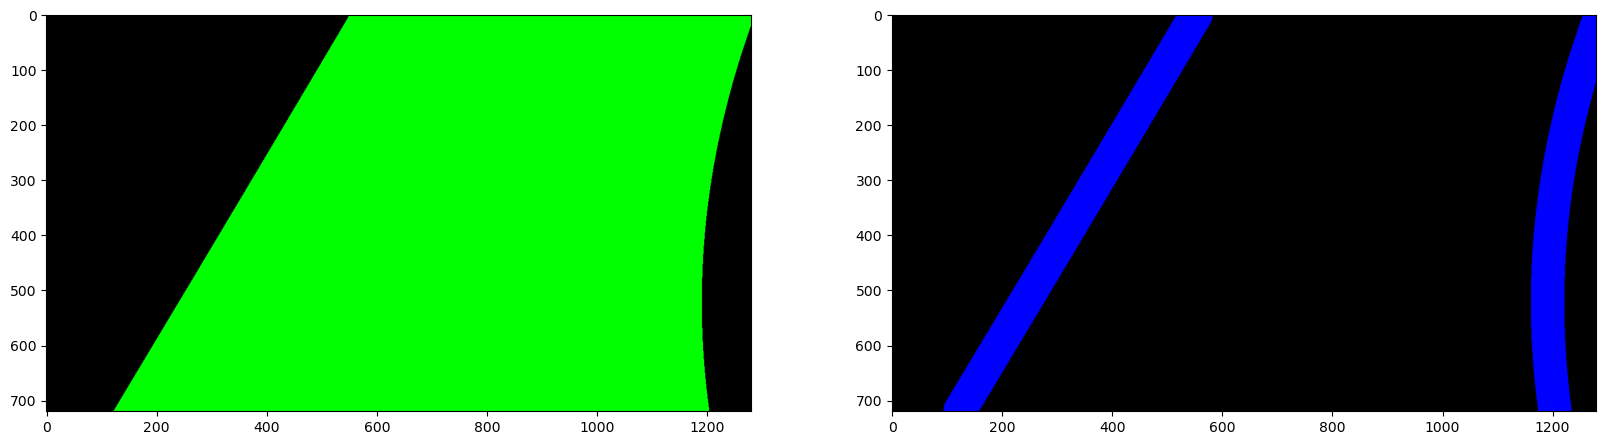

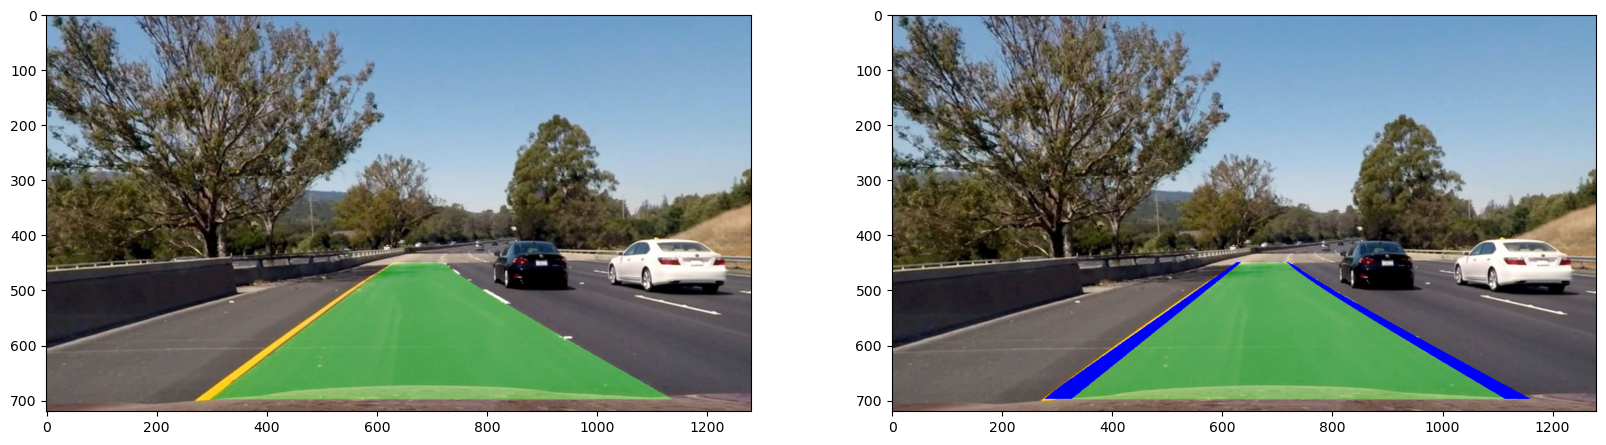

In [7]:
# Draw shapes on polygon and transform back to original

warp_poly = np.zeros((h, w, 3), np.uint8)
warp_lines = np.zeros((h, w, 3), np.uint8)
alpha = 0.5 # opacity of overlayed polygon

# Create Stack out of points for each line
left_curve_stack = np.stack((left_xn, left_yn), axis=-1)
right_curve_stack = np.stack((right_xn, right_yn), axis=-1)

# create array containing both lines
pts = np.array([left_curve_stack, right_curve_stack[::-1]], np.int32)
pts = pts.reshape((-1,1,2))

# fill space between lines with (green) polygon
cv.fillPoly(warp_poly, [pts], (0,255,0))
# warp_overlayed = cv.addWeighted(warp_poly, alpha, np.zeros((h, w, 3), np.uint8), 1 - alpha, 0)

# Draw both lines in image (blue)
cv.polylines(warp_lines, pts, isClosed = True, color = (255, 0, 0), thickness = 60)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(warp_poly, cv.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(warp_lines, cv.COLOR_BGR2RGB))
plt.show()

# transform shapes back ot original proportions
M = cv.getPerspectiveTransform(dst,src)

transform_back = cv.warpPerspective(warp_poly,M,(w, h))
original_overlayed = img1
original_overlayed = cv.addWeighted(transform_back, alpha, original_overlayed, 1-alpha, 1)
original_overlayed = np.where(transform_back == 0, img1, original_overlayed)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(original_overlayed, cv.COLOR_BGR2RGB))

transform_back = cv.warpPerspective(warp_lines,M,(w, h))
original_overlayed[:,:,0] = np.where(transform_back[:,:,0] == 255, 255, original_overlayed[:,:,0])
original_overlayed[:,:,1] = np.where(transform_back[:,:,0] == 255, 0, original_overlayed[:,:,1])
original_overlayed[:,:,2] = np.where(transform_back[:,:,0] == 255, 0, original_overlayed[:,:,2])

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(original_overlayed, cv.COLOR_BGR2RGB))
plt.show()

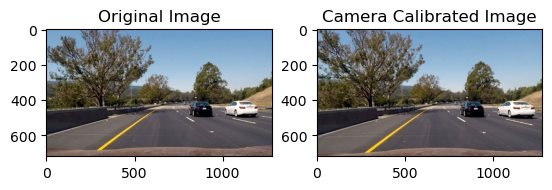

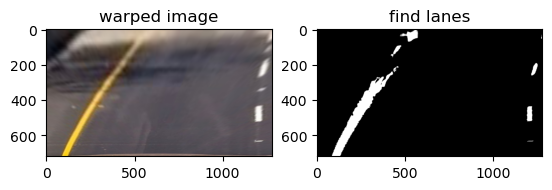

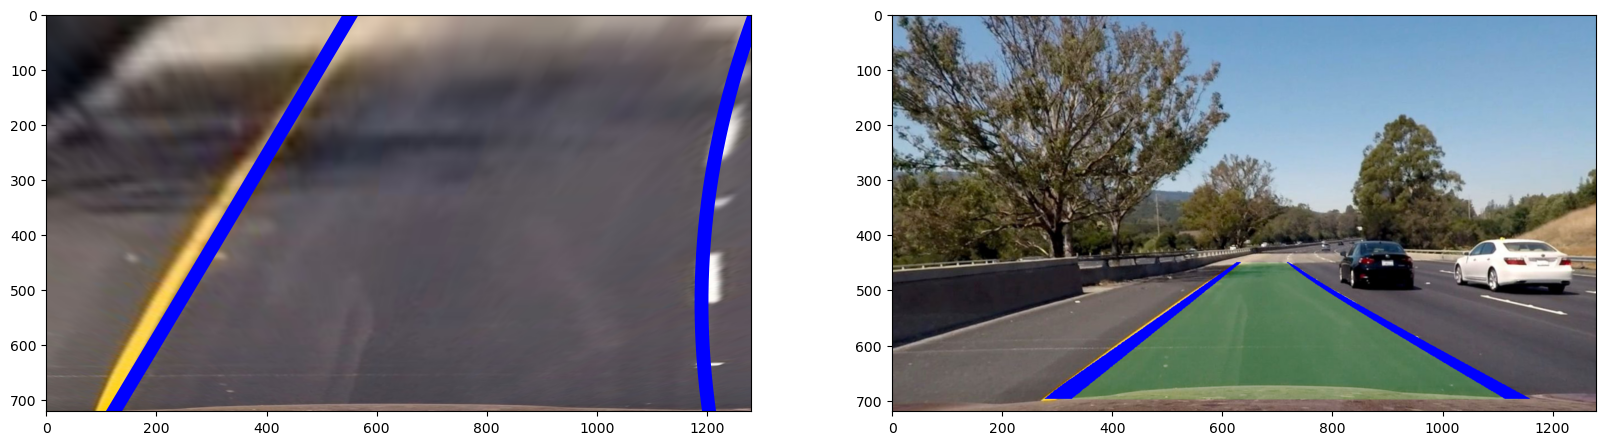

True

In [20]:
## All Steps at once

# Load example image
img_name = "image003.jpg"
img1 = cv.imread('./img/Udacity/' + img_name, -1)
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Original Image')

h,  w = img1.shape[:2]

# Undistort image using predefined Camera Matrix
img1 = cv.undistort(img1, mtx, dist, None, mtx)
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Camera Calibrated Image')
plt.show()

# Define Perspektive Transform Corners
src = np.float32(((560, 450), (720, 450), (200, 700), (1200, 700)))
dst = np.float32(((0, 0), (w, 0), (0, h), (w, h)))

# Apply Perspektive transform
M = cv.getPerspectiveTransform(src,dst)
img1_warp = cv.warpPerspective(img1,M,(img1.shape[1], img1.shape[0]))
plt.subplot(1,2,1)
plt.title("warped image")
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))

# Apply Filters to find lines
# black_white = np.where(cv.cvtColor(img1_warp, cv.COLOR_BGR2GRAY) > 180, np.uint8(255), np.uint8(0))
filtered_lines = filter_yellow_and_white_lines(img1_warp)
plt.subplot(1,2,2)
plt.title("find lanes")
plt.imshow(filtered_lines, cmap='gray')
plt.show()

# define width and height of transformed image
w = len(filtered_lines[1])
h = len(filtered_lines)

# Split image and filter for single points
left_half = filtered_lines[:,0:int(w/2)]
right_half = filtered_lines[:,int(w/2):w]

kernel = np.array([[1,0,-1],[1,0,-1],[1,0,-1]],np.float32)
left_half = cv.filter2D(left_half,-1,kernel)
kernel = np.array([[-1,0,1],[-1,0,1],[-1,0,1]],np.float32)
right_half = cv.filter2D(right_half,-1,kernel)

# Get Array of point coordinates from image

# Get white pixel coordinates for each half
left_y, left_x = np.where(left_half == np.uint32(255))
right_y, right_x = np.where(right_half == np.uint32(255))

# Determine Polynomial Function representing the white pixel for each half

def get_poly(x_n, y_n):
    """
    get_poly Determine the second degree polynomial function representing the points defined in the input arrays
    Uses np.polyfit

    Args:
        x_n (Array): X values of points 
        y_n (Array): Y values of points

    Returns:
        (Array, Array): Arrays containing key pints defining a second degree polynomial Function
    """
    w = np.polyfit(y_n, x_n, 2)

    xn = np.arange(0, h, 1)
    yn1 = np.poly1d(w)(xn)

    return (xn, yn1)

# Get representative Polynomial funciton for each half 
left_yn, left_xn = get_poly(left_x, left_y)
right_yn, right_xn = get_poly(right_x, right_y)


# Shift right curve to the right to display it correctly
right_xn += np.uint32(w/2) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
plt.plot(left_xn, left_yn, '-b', linewidth = 10, label='Polyn. 2. Grades')
plt.plot(right_xn, right_yn, '-b',  linewidth = 10, label='Polyn. 2. Grades')

plt.xlim([0, w])
plt.ylim([h, 0])


# Draw shapes on polygon and transform back to original

# init black image for polygon
warp_poly = np.zeros((h, w, 3), np.uint8)
#init black image for lines
warp_lines = np.zeros((h, w, 3), np.uint8)
alpha = 0.25 # opacity of overlayed polygon

# Create Stack out of points for each line
left_curve_stack = np.stack((left_xn, left_yn), axis=-1)
right_curve_stack = np.stack((right_xn, right_yn), axis=-1)

# create array containing both lines
pts = np.array([left_curve_stack, right_curve_stack[::-1]], np.int32)
pts = pts.reshape((-1,1,2))

# fill space between lines with (green) polygon
cv.fillPoly(warp_poly, [pts], (0,255,0))

# Draw both lines in image (blue)
cv.polylines(warp_lines, pts, isClosed = True, color = (255, 0, 0), thickness = 60)

# transform poylgon back to original proportions
M = cv.getPerspectiveTransform(dst,src)
transform_back = cv.warpPerspective(warp_poly,M,(w, h))

# overlay polygon with limited opacity onto road
original_overlayed = img1
original_overlayed = cv.addWeighted(transform_back, alpha, original_overlayed, 1-alpha, 1)
original_overlayed = np.where(transform_back == 0, img1, original_overlayed)

# transform lines back to original proportions
transform_back = cv.warpPerspective(warp_lines,M,(w, h))
original_overlayed[:,:,0] = np.where(transform_back[:,:,0] == 255, 255, original_overlayed[:,:,0])
original_overlayed[:,:,1] = np.where(transform_back[:,:,0] == 255, 0, original_overlayed[:,:,1])
original_overlayed[:,:,2] = np.where(transform_back[:,:,0] == 255, 0, original_overlayed[:,:,2])

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(original_overlayed, cv.COLOR_BGR2RGB))
plt.show()

cv.imwrite('./results/' + img_name +'_result.jpg', original_overlayed)



# Ausblick auf weitere Teilaufgaben
- Bestimmung der Kurvenkrümmung anhand von Polynom-Fiting